In [1]:
%cd ../src/

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/testing/gymming/src


In [2]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm

from cav import CAV
from concepts import concept_instances
from dqn import load_model
from utils import prepare_folders

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models_path = "../runs/20230917-010123/models/"
models = os.listdir(models_path)
# get num steps from file name
models = [(f, int(f.split('_')[1].replace('.pt',''))) for f in models if f.endswith(".pt")]
# sort on the number of steps
models.sort(key=lambda x: x[1])

In [4]:
random_concept = concept_instances[0]
layers = [0,1,2,3,4,5,6,8,9] # exclude 7 since its flatten (9 is q values)
train_steps = [m[1] for m in models]
concept_data = {}

# setup 3d data structures for plotting
for concept in concept_instances:
    concept_data[concept.name] = {}
    x, y = np.meshgrid(train_steps, layers)
    concept_data[concept.name]['x'] = x
    concept_data[concept.name]['y'] = y
    concept_data[concept.name]['z'] = np.zeros((len(layers), len(train_steps)))

In [5]:
# calculate test accuracy for each point: (concept, training_step, layer)
for model_name in models:
    model, steps = model_name
    steps_index = train_steps.index(steps)
    q_network = load_model(models_path + model).to(device)
    print("Loaded model: ", model)
    for concept in concept_instances:
        cav = CAV(concept, random_concept, q_network, layers, device)
        cav.generate_cavs(k=10)
        accuracies = cav.lm_test_set_accuracies
        for layer_index, layer in enumerate(layers):
            concept_data[concept.name]['z'][layer_index][steps_index] = accuracies[layer]
        cav.close()

Loaded model:  model_0.pt
Loaded model:  model_3.pt
Loaded model:  model_10.pt
Loaded model:  model_31.pt
Loaded model:  model_100.pt
Loaded model:  model_316.pt
Loaded model:  model_1000.pt
Loaded model:  model_3162.pt
Loaded model:  model_10000.pt
Loaded model:  model_31622.pt
Loaded model:  model_100000.pt
Loaded model:  model_316227.pt
Loaded model:  model_1000000.pt
Loaded model:  model_3162277.pt


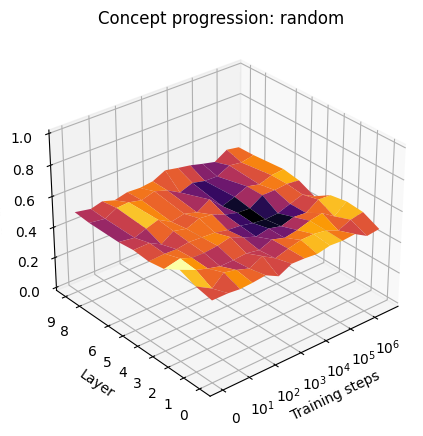

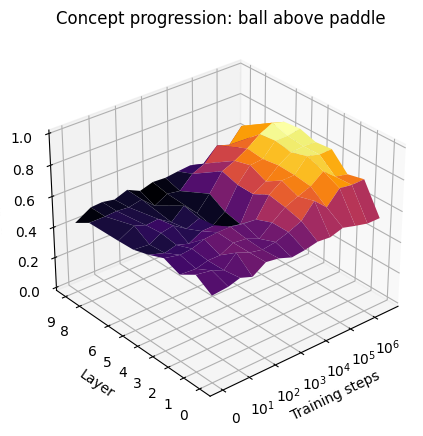

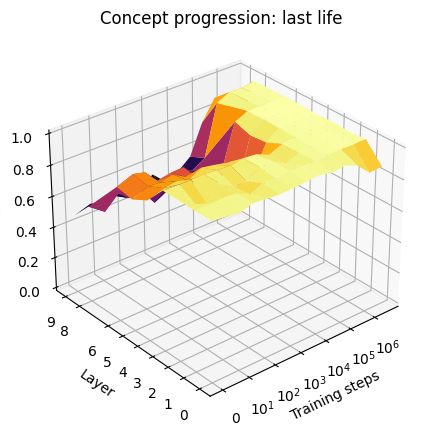

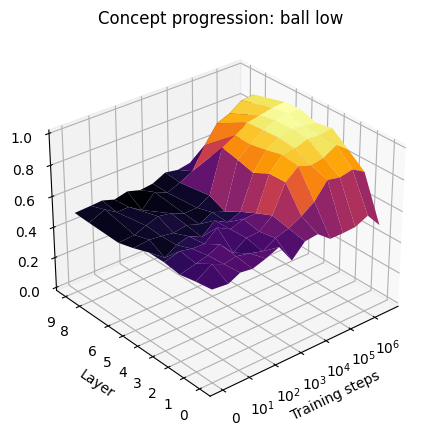

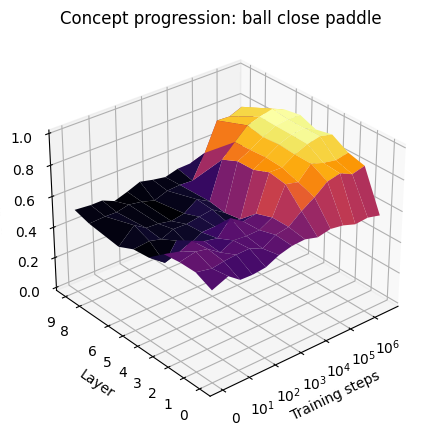

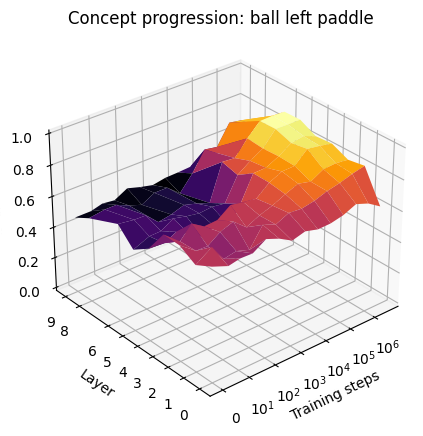

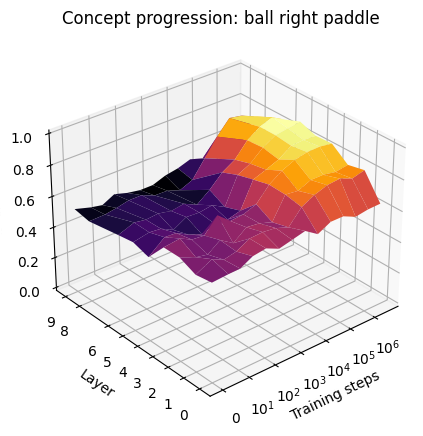

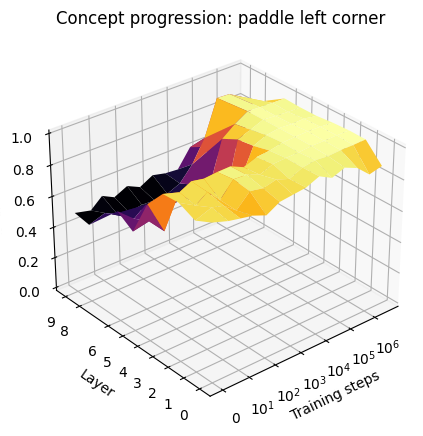

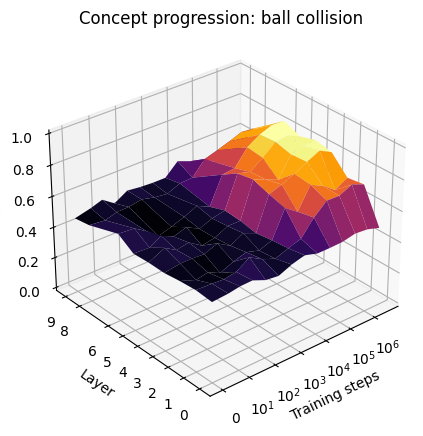

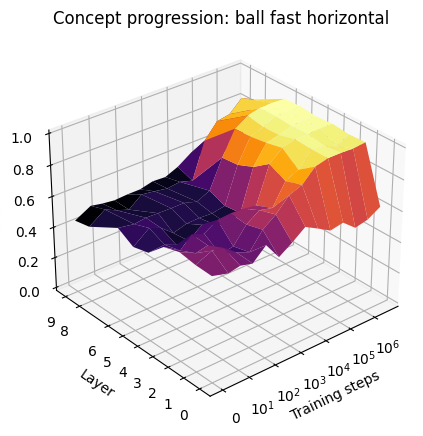

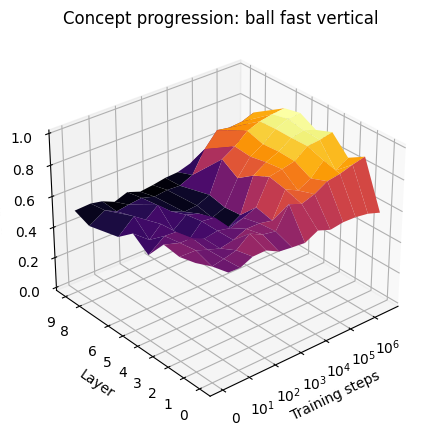

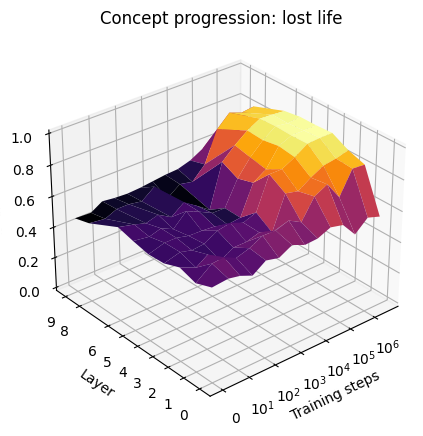

In [6]:
train_steps = np.array(train_steps)

# surface plot accuracies, log10 scale for training steps
for concept in concept_instances:
    data = concept_data[concept.name]

    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection='3d')
    ax.set_title(f'Concept progression: {concept.name}')
    ax.view_init(elev=30, azim=-130)
    ax.plot_surface(np.log10(data['x']+1), data['y'], data['z'], cmap=cm.inferno)

    ax.set_xlabel('Training steps')
    ax.set_xticks(np.log10([1, 10, 100, 1000, 10000, 100000, 1000000]))
    ax.set_xticklabels(['$0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$'])

    ax.set_ylabel('Layer')
    ax.set_yticks(layers)
    ax.set_yticklabels(layers)

    ax.set_zlabel('Accuracy')
    ax.set_zlim(0, 1)
    
    plt.savefig(f'{concept.path}/cavs/concept_progression.png')